# Text classification using Naive Bayes Classifier

## Exercise 1

Open the data. Find out how many spam and not spam e-mails it contains. Visualize spam/not spam ratio.

In [37]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import plotly.express as px

In [38]:
sms_data = pd.read_csv('data/spam_or_not_spam.csv')
sms_data.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [39]:
sms_data['label'].value_counts()

label
0    2500
1     500
Name: count, dtype: int64

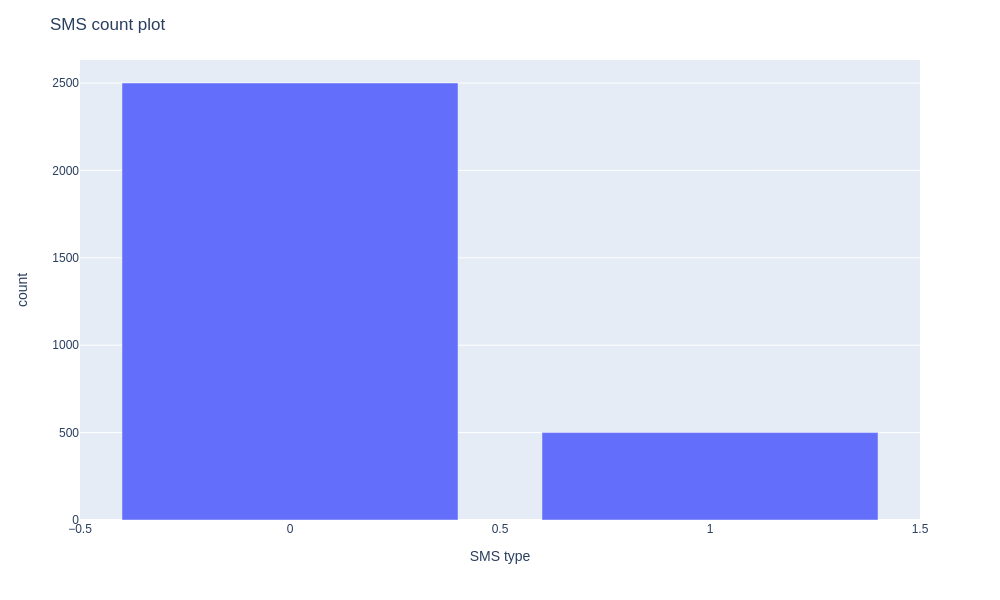

In [40]:
fig_classes = px.bar(
    sms_data['label'].value_counts(),
    orientation='v'
)

fig_classes.update_layout(
    autosize=False,
    width=1000,
    height=600,
    showlegend=False,
    title_text="SMS count plot"
)

fig_classes.layout.xaxis.title='SMS type'
fig_classes.layout.yaxis.title='count'
fig_classes.write_html('images/class.html')
fig_classes.write_image('images/class.png')
fig_classes.show('png')
# fig_classes.show()

> Spam SMS is five times less than not spam ones. Target feature is disbalanced. Samples should be stratified when splitted.

## Exercise 2

Preprocess the data then vectorize it. Import necessary module:

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

Replace all emply strings and strings containing only spaces with NaN. Then remove those strings from the data.

In [42]:
sms_data.dropna(axis=0, inplace=True)
sms_data['email'] = sms_data['email'].apply(lambda x: x.lower().strip())
sms_data['email'] = sms_data['email'].apply(lambda x: np.nan if len(x) == 0 else x)
sms_data.dropna(axis=0, inplace=True)

Vectorize the data:

In [43]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(sms_data['email'])

Determine how many features we have:

In [44]:
print(f'Number of features: {X.shape[1]}')

Number of features: 34116


> The result of this stage is a sparse matrix with number of unique words as number of its rows.

## Exercise 3

Determine the target and factors:

In [45]:
y = sms_data['label']

Split the sample on train and test parts using stratified split (set `stratify` parameter equal to y), set shape of test sample (`test_size`) to $0.25$, set parameter `random_state` to $42$:

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, stratify=y, random_state=42)
print(f'Train sample shape: {X_train.shape}')
print(f'Test sample shape: {X_test.shape}')

Train sample shape: (2247, 34116)
Test sample shape: (750, 34116)


Calculate target's mean value on test sample:

In [48]:
print(f'y mean value, test sample: {y_test.mean():.3f}')

y mean value, test sample: 0.165


> Because of imbalance in target stratifying of samples is mandatory.

## Exercise 4

Define and learn convenient algorithm with `alpha = 0.01`

In [49]:
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve

In [50]:
cnb = ComplementNB(alpha=0.01)
cnb.fit(X_train, y_train)

ComplementNB(alpha=0.01)

Estimate the result regarding the metrics:

In [51]:
y_train_pred = cnb.predict(X_train)
y_test_pred = cnb.predict(X_test)
cnb_df = pd.DataFrame({'Score': ['Recall', 'Precision', 'F1'],
                       'Train': [np.round(recall_score(y_train, y_train_pred), 3), 
                                 np.round(precision_score(y_train, y_train_pred), 3), 
                                 np.round(f1_score(y_train, y_train_pred), 3)],
                       'Test': [np.round(recall_score(y_test, y_test_pred), 3), 
                                np.round(precision_score(y_test, y_test_pred), 3), 
                                np.round(f1_score(y_test, y_test_pred), 3)]})
cnb_df

,Score,Train,Test
0,Recall,0.997,0.927
1,Precision,1.000,1.000
2,F1,0.999,0.962


Draw ROC line:

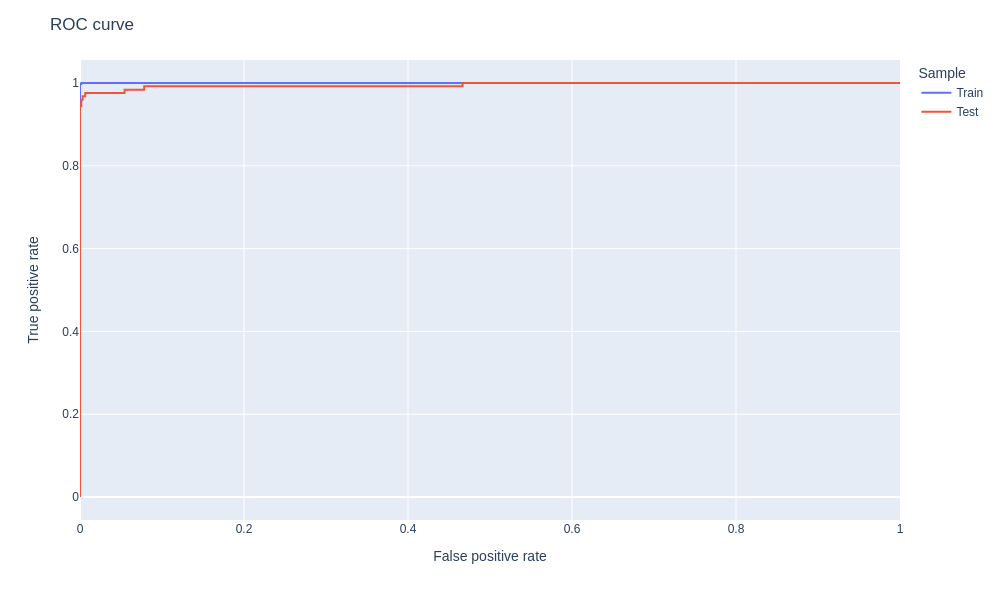

In [52]:
fpr_train, tpr_train, _ = roc_curve(y_train, cnb.predict_proba(X_train)[:, 1], pos_label=1)
fpr_test, tpr_test, _ = roc_curve(y_test, cnb.predict_proba(X_test)[:, 1], pos_label=1)

train_roc_df = pd.DataFrame({'Sample': 'Train', 'TPR': tpr_train, 'FPR': fpr_train})
test_roc_df = pd.DataFrame({'Sample': 'Test', 'TPR': tpr_test, 'FPR': fpr_test})
roc_df = pd.concat([train_roc_df, test_roc_df], ignore_index=True)

fig_roc = px.line(roc_df, x='FPR', y='TPR', color='Sample')
fig_roc.update_layout(
        autosize=False,
        width=1000,
        height=600,
        title_text="ROC curve"
    )

fig_roc.update_xaxes(title_text='False positive rate')
fig_roc.update_yaxes(title_text='True positive rate')
fig_roc.update(layout_showlegend=True)
fig_roc.write_html('images/roc.html')
fig_roc.write_image('images/roc.png')
fig_roc.show('png')
# fig_roc.show()

> The model demonstrates high quality results. ROC curve on train sample is almost ideal. Metrics on test sample are slightly worse but still there's no sign of overfitting.

## Exercise 5

Cycle through some `alpha` range using cross-validation. Conclude whether the quality of classification depends on `alpha` value.

In [53]:
from sklearn.model_selection import cross_val_score

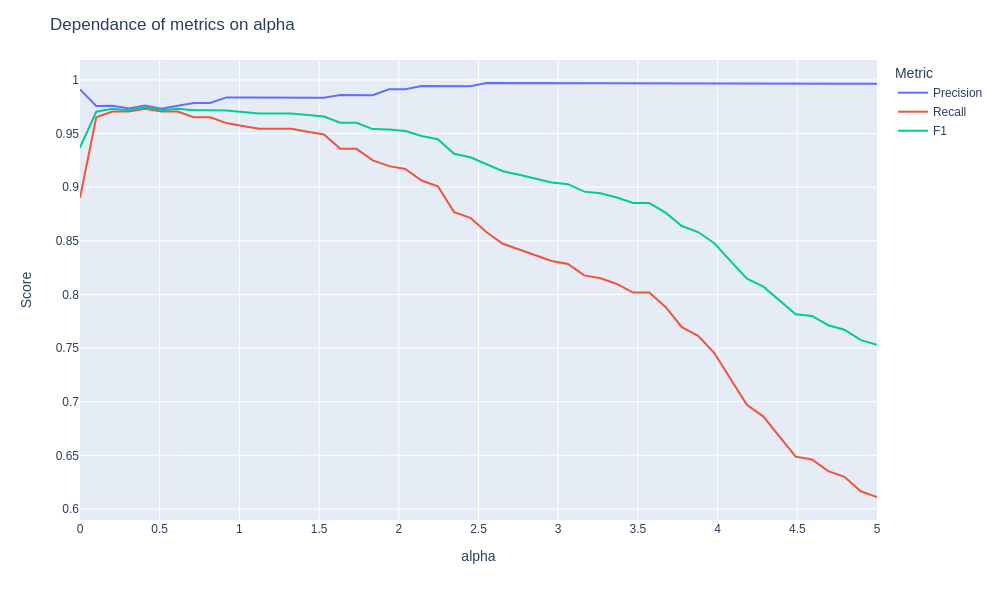

In [54]:
alpha_range = np.linspace(0.000001, 5, 50)
recall_list = []
precision_list = []
f1_list = []

for alpha in alpha_range:
    cnb_var = ComplementNB(alpha=alpha)
    
    prec = cross_val_score(cnb_var, X_train, y_train, cv=5, scoring='precision')
    recall = cross_val_score(cnb_var, X_train, y_train, cv=5, scoring='recall')
    f1 = cross_val_score(cnb_var, X_train, y_train, cv=5, scoring='f1')
    
    precision_list.append(prec.mean())
    recall_list.append(recall.mean())
    f1_list.append(f1.mean())

cv_precision_df = pd.DataFrame({'Metric': 'Precision', 'alpha': alpha_range, 'Score': precision_list})
cv_recall_df = pd.DataFrame({'Metric': 'Recall', 'alpha': alpha_range, 'Score': recall_list})
cv_f1_df = pd.DataFrame({'Metric': 'F1', 'alpha': alpha_range, 'Score': f1_list})

cv_metrics_df = pd.concat([cv_precision_df, cv_recall_df, cv_f1_df], ignore_index=True)

fig_cv_metrics = px.line(cv_metrics_df, x='alpha', y='Score', color='Metric')
fig_cv_metrics.update_layout(
        autosize=False,
        width=1000,
        height=600,
        title_text="Dependance of metrics on alpha"
    )

fig_cv_metrics.update_xaxes(title_text='alpha')
fig_cv_metrics.update_yaxes(title_text='Score')
fig_cv_metrics.update(layout_showlegend=True)
fig_cv_metrics.write_html('images/cv.html')
fig_cv_metrics.write_image('images/cv.png')
fig_cv_metrics.show('png')
# fig_cv_metrics.show()

> The figure demonstrates that quality of classification depends on alpha value. The highest f1 score can be achieved when $alpha = 0.4$. When $alpha > 0.4$ the larger alpha value the lower recall and f1 scores.